<a href="https://colab.research.google.com/github/LargeMan/CAP4630/blob/master/HW_4/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4
## Problem 1
Import relevant libraries

In [0]:
import math
import typing
import numpy as np
import matplotlib.pyplot as plt

# Convolution of two 2d matrices
To perform convolution between two 2d matrices, the following steps are taken:


*   Pad the array based on the radius of the kernel. However, since this problem requires VALID padding, no padding is done, but instead the rightmost elements and bottommost elements are dropped if the kernel doesn't perfectly match the dimensions per stride.
*   Double flip the kernel matrix
*   For each element in input matrix, multiply all it as well as its neighbors within the range of the kernel's size by the respective element in the flipped kernel, then add it all together and put it in the respective index of the output matrix



In [0]:
def conv2d(input_mat: np.ndarray, kernel_mat: np.ndarray,
           stride=(1,1), pad='VALID', square=True):
  ''' Convolves an input matrix by an input kernel/mask '''
  
  # Error handling Suite
  # Check type
  if not (isinstance(input_mat, np.ndarray)
       or isinstance(kernel_mat, np.ndarray)):
    raise ValueError("ERROR: one or more inputs are not numpy arrays!")

  mask_size = kernel_mat.size
  # Check sizes
  if mask_size == 0 or input_mat.size == 0:
    raise ValueError("ERROR: input and/or kernel are empty!")

  if mask_size > input_mat.size:
    raise ValueError("ERROR: kernel is larger than input!")

  # Check if mask is not square (3x3, 5x5, etc)
  mask_len = kernel_mat[0].size
  input_size = input_mat.size
  input_len = input_mat[0].size
  if (mask_size/mask_len != mask_len
    or (input_size/input_len != input_len and square)):
    raise ValueError("ERROR: one or more inputs are not square!")

  
  try:
    # Get mask radius
    mr = int(mask_len/2)

    # return multiplication by scalar if kernel is 1x1 matrix
    if mr == 0: return input_mat * kernel_mat[0]

    # pad the array (or not if VALID)
    if pad == 'VALID':
      pad_mat = input_mat
      xshape = input_mat.shape[0] - mask_len + 1
      yshape = input_mat.shape[1] - mask_len + 1
    else:
      pad_mat = np.pad(input_mat, pad_width = mr, mode='constant',
                       constant_values=0)
      xshape, yshape = input_mat.shape
    
    # double flip the mask
    mask = np.flip(kernel_mat)

    # adjust mask end indices (to make the convolution logic work)
    if not (mask_len & 0x1):
      end = mr
    else:
      end = mr+1


    # Convolution performed below
    
    output_mat = np.zeros((int(xshape/stride[0]),
                           int(yshape/stride[1])))
    # Go through every applicable column and row
    for i in range(mr, xshape+mr, stride[0]):
      for j in range(mr, yshape+mr, stride[1]):
        sum1 = 0
        # Multiply corresponding mask & input elements and add total
        for p in range(-mr, end):
          for q in range(-mr, end):
            sum1 += pad_mat[i+p][j+q] * mask[p+mr][q+mr]
        output_mat[i-mr][j-mr] = sum1
  
  except Exception as e:
    print(e)
    return None

  return output_mat

### Example of 1x1 kernel output

In [0]:
conv2d(np.ones((8,8)), np.ones((3,3)))

array([[9., 9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9., 9.],
       [9., 9., 9., 9., 9., 9.]])

### Sobel edge detection example
The sobel edge detection method requires convolution with two seperate masks, and the final output is the magnitude of the two outputs normalized.

To test this, an image of a cat is imported and converted to grayscale

Note that the input image is not square; however, the way conv2d is implemented here allows for nonsquare input_mat. This "feature" can be turned on or off via the "square" flag, and so for this example it will be turned on. Regardless of the flag, the kernel matrix must still be square.

In [0]:
import skimage.data
test_input = skimage.data.chelsea()
test_input = skimage.color.rgb2gray(test_input)
test_input.shape

(300, 451)

In [0]:
maskX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
maskY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

outX = conv2d(test_input, maskX, square=False)
outY = conv2d(test_input, maskY, square=False)

sobel = np.zeros(outX.shape)
maxval = 0

# get magnitudes
for i in range(outX.shape[0]):
  for j in range(outX.shape[1]):
    sobel[i][j] = math.sqrt((outX[i][j]**2)+(outY[i][j]**2))
    if sobel[i][j] > maxval:
      maxval = sobel[i][j]

# normalize (not necessarily required)
for i in range(outX.shape[0]):
  for j in range(outX.shape[1]):
    sobel[i][j] = (sobel[i][j]/maxval) * 255

### Original cat image

(300, 451)

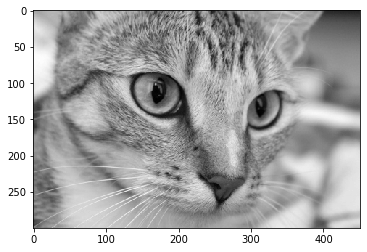

In [0]:
plt.imshow(test_input, cmap='gray', interpolation='nearest')
test_input.shape

### Sobel output

(298, 449)

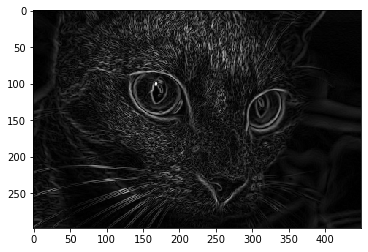

In [0]:
plt.imshow(sobel, cmap='gray', interpolation='nearest')
sobel.shape

# Problem 2
The maxpooling operation looks at each S x S segment of an input matrix, where S is an input integer, and returns a smaller matrix where each element is the max of each segment.

In [0]:
def maxpooling2d(input_mat: np.ndarray, s: int, square=True):
  ''' Maxpooling operation, where window is of size s*s '''

  window = s*s
  # Error if window is larger than input
  if window > input_mat.size:
    raise ValueError("ERROR: window size {} is larger " +
                     "than input size {}!".format(window, input_mat.size))
  # Error if input is not square (can be disabled with flag)
  if (input_mat.shape[0] != input_mat.shape[1]) and square:
    raise ValueError("ERROR: one or more inputs are not square!")


  h2 = int(input_mat.shape[0]/s)
  w2 = int(input_mat.shape[1]/s)

  output_mat = np.zeros((h2, w2))
  for i in range(s-1, input_mat.shape[0], s):
    for j in range(s-1, input_mat.shape[1], s):
      maxpool = 0
      for p in range(s):
        for q in range(s):
          maxpool = max(maxpool, input_mat[i-p][j-q])
      x = int(i/s)
      y = int(j/s)
      #print('{}'.format([x, y]))
      output_mat[x][y] = maxpool
      

  return output_mat

(37, 56)

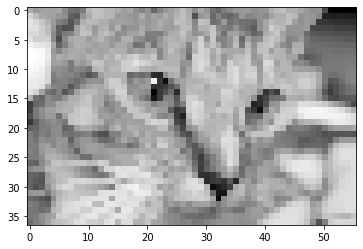

In [0]:
maxpooltest = maxpooling2d(test_input, 8, square=False)
plt.imshow(maxpooltest, cmap='gray', interpolation='nearest')
maxpooltest.shape

# Full Problem 1 Test Cases

Note: Test case 5 results in an error; this is intentional




In [0]:
from scipy import signal
import numpy as np

input_mat = []
kernel_mat = []
expected_mat = []

# test case 1
input_mat.append(np.array([[1, 2, 1, 2],
                      [2, 1, 2, 1],
                      [1, 2, 1, 2],
                      [2, 1, 2, 1]]))

kernel_mat.append(np.array([[1, 0],
                       [0, 1]]))

expected_mat.append(np.array([[2, 4, 2],
                                [4, 2, 4],
                                [2, 4, 2]]))

# test case 2
input_mat.append(np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]]))
kernel_mat.append(np.array([[1, 0], [0, 1]]))
expected_mat.append(np.array([[2, 0, 0], [0, 2, 0], [0, 0, 2]]))


# test case 3
input_mat.append(np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]]))
kernel_mat.append(np.array([[1, -1],
                       [-1, 0]]))

expected_mat.append(np.array([[ 1, -1,  0], [-1,  1, -1],[ 0, -1,  1]]))


# test case 4
input_mat.append(np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]]))
kernel_mat.append(np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]]))

expected_mat.append(np.array([[4]]))


# test case 5 - should either throw an error, or return empty matrix
input_mat.append(np.array([[1, -1],
                       [-1, 0]]))
kernel_mat.append(np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]]))

expected_mat.append([])



for i in range(len(input_mat)):
  # uncomment line for student code testing
  output_mat = conv2d(input_mat[i], kernel_mat[i])

  print(output_mat)
  if np.array_equal(output_mat, expected_mat[i]):
    print("Correct output!\n")
  else:
    print("Incorrect output!\n")

[[2. 4. 2.]
 [4. 2. 4.]
 [2. 4. 2.]]
Correct output!

[[2. 0. 0.]
 [0. 2. 0.]
 [0. 0. 2.]]
Correct output!

[[ 1. -1.  0.]
 [-1.  1. -1.]
 [ 0. -1.  1.]]
Correct output!

[[4.]]
Correct output!



ValueError: ignored

# Full Problem 2 Test Cases

In [0]:
import skimage.measure

input_mat = []
expected_mat = []
s = []
input_mat.append(np.array([[1, 2, 1, 2],
                      [2, 4, 2, 1],
                      [1, 2, 4, 2],
                      [2, 1, 2, 1]]))
s.append(2)

expected_mat.append(np.array([[4, 2],
                                [2, 4]]))

input_mat.append(np.array([[1, 2, 1, 2, 4, 5],
                      [2, 4, 2, 1, 0, 3],
                      [1, 2, 4, 2, 4, 5],
                      [2, 1, 2, 1, 2, 1],
                      [1, 1, 2, 3, 1, 2],
                      [1, 1, 2, 3, 1, 2]]))
s.append(2)

expected_mat.append([[4, 2, 5],
 [2, 4, 5],
 [1, 3, 2]])


for i in range(len(input_mat)):
  output_mat = maxpooling2d(input_mat[i], s[i])
  print(output_mat)

  if np.array_equal(output_mat, expected_mat[i]):
    print("Correct output!")
  else:
    print("Incorrect output!")

[[4. 2.]
 [2. 4.]]
Correct output!
[[4. 2. 5.]
 [2. 4. 5.]
 [1. 3. 2.]]
Correct output!


In [6]:
input_mat = np.array([[1,2,3],
                      [4,5,6],
                      [7,8,9]])
kernel_mat = [[1,0],
              [0,2]]

print(conv2d(input_mat, kernel_mat))

NameError: ignored